# Data Augmentation

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_09c import *

## PIL transforms

We start with PIL transforms to resize all our images to the same size. Then, when they are in a batch, we can apply data augmentation to all of them at the same time on the GPU. We have already seen the basics of resizing and putting on the GPU in 08, but we'll look more into it now.

### View images

In [3]:
#export
make_rgb._order = 0

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [5]:
#!rm -rf /root/.fastai/data/imagenette /root/.fastai/data/imagenette.tgz

In [6]:
def get_il(tfms):
    return ImageList.from_files(path, tfms=tfms)

In [7]:
il = get_il(tfms)

In [8]:
img_index = 2523

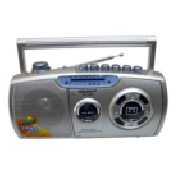

In [9]:
show_image(il[img_index])

In [10]:
il[img_index].shape, il.items[img_index]

(torch.Size([3, 128, 128]),
 PosixPath('/root/.fastai/data/imagenette/train/n02979186/n02979186_8889.JPEG'))

In [11]:
img = PIL.Image.open(il.items[img_index])

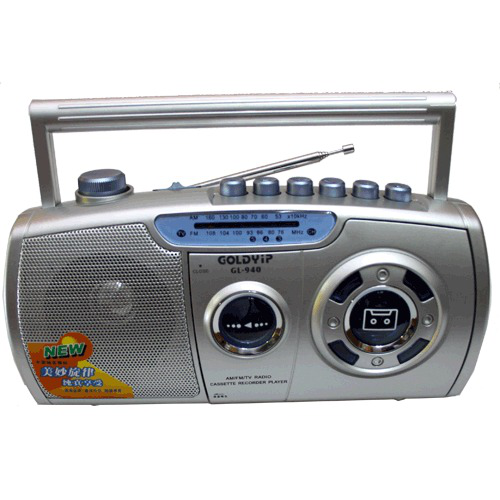

In [12]:
img

In [13]:
img.getpixel((0,0))

(255, 255, 255)

In [14]:
import numpy as np

In [15]:
%timeit -n 100 a = np.array(PIL.Image.open(il.items[0]))

5 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Be careful of resampling methods, you can quickly lose some textures!

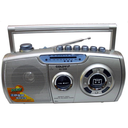

In [16]:
img.resize((128, 128), resample=PIL.Image.ANTIALIAS)

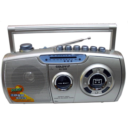

In [17]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

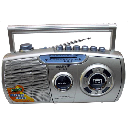

In [18]:
img.resize((128,128), resample=PIL.Image.NEAREST)

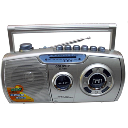

In [19]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

In [20]:
%timeit img.resize((224, 224), resample=PIL.Image.BICUBIC)

2.24 ms ± 5.73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit img.resize((224,224), resample=PIL.Image.BILINEAR)

1.29 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%timeit -n 10 img.resize((224,224), resample=PIL.Image.NEAREST)

37.7 µs ± 4.15 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Flip

Flip can be done with PIL very fast.

In [23]:
#export
import random

In [24]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() <  0.5 else x

In [25]:
bs = 8
il1 = get_il(tfms)
il1.items = [il1.items[img_index]] * 64
dl = DataLoader(il1, bs)

In [26]:
x = next(iter(dl))

In [27]:
x.shape

torch.Size([8, 3, 128, 128])

Here is a convenience function to look at images in a batch.

In [28]:
#export
def show_image(im, ax=None, figsize=(3, 3)):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1, 2, 0))

In [29]:
#export
def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None:
        r = int(math.ceil(n / c))
    if figsize is None:
        figsize = (c * 3, r * 3)
    fig, axes = plt.subplots(r, c, figsize=figsize)
    for xi, ax in zip(x, axes.flat):
        show_image(xi, ax)

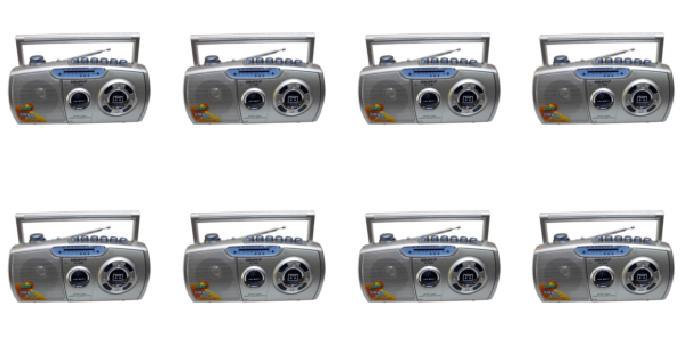

In [30]:
show_batch(x)

With random flip:

In [31]:
il1.tfms.append(pil_random_flip)

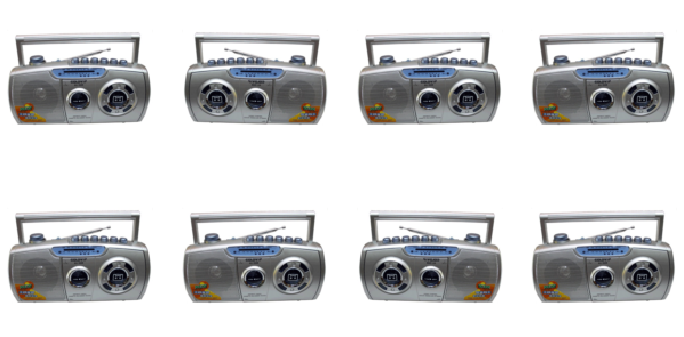

In [32]:
x = next(iter(dl))
show_batch(x)

In [33]:
??Transform

In [34]:
class PilRandomFlip(Transform):
    _order=11
    
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

In [35]:
#export
class PilTransform(Transform):
    _order = 11
    
class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

In [36]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(p=0.8))

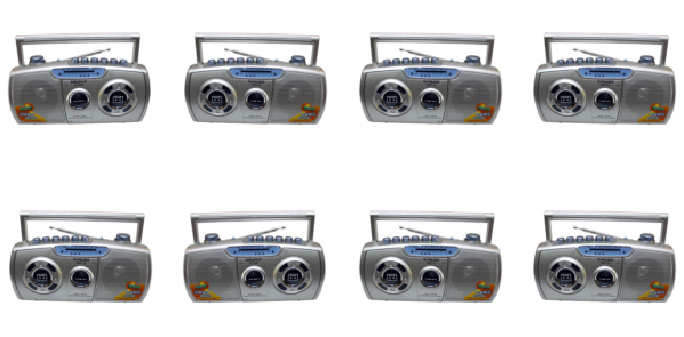

In [37]:
x = next(iter(dl))
show_batch(x)

PIL can also do the whole dihedral group of transformations (random horizontal flip, random vertical flip and the four 90 degrees rotation) with the `transpose` method. Here are the codes of a few transformations:

In [38]:
PIL.Image.FLIP_LEFT_RIGHT,PIL.Image.ROTATE_270,PIL.Image.TRANSVERSE

(0, 4, 6)

Be careful that `img.transpose(0)` is already one transform, so doing nothing requires a separate case, then we have 7 different transformations.

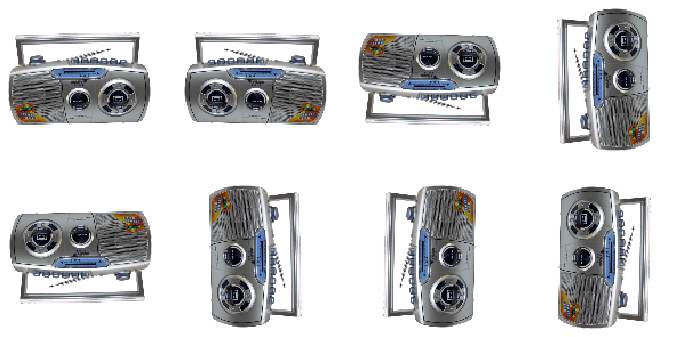

In [39]:
img = PIL.Image.open(il.items[img_index])
img = img.resize((128, 128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        ax.imshow(img)
    else:
        ax.imshow(img.transpose(i - 1))
    ax.axis('off')

And we can implement it like this:

In [40]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75):
        self.p = p * 7 / 8
    
    def __call__(self, x):
        if random.random() > self.p:
            return x
        else:
            return x.transpose(random.randint(0, 6))

In [41]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

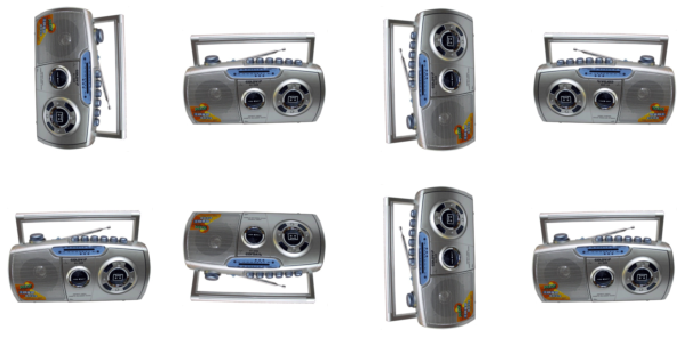

In [42]:
show_batch(next(iter(dl)))

### Random crop

In [43]:
img = PIL.Image.open(il.items[img_index])
img.size

(500, 500)

To crop an image with PIL we have to specify the top/left and bottom/right corner in this format: (left, top, right, bottom). We won't just crop the size we want, but first crop the section we want of the image and then apply a resize. In what follows, we call the first one the `crop_size`.

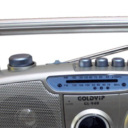

In [44]:
img.crop((60, 60, 320, 320)).resize((128, 128), resample=PIL.Image.BILINEAR)

In [45]:
cnr2 = (60, 60, 320, 320)
resample = PIL.Image.BILINEAR

This is pretty fast in PIL:

In [46]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

406 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our time budget: aim for 5 mins per batch for imagenet on 8 GPUs. 1.25m images in imagenet. So on one GPU per minute that's `1250000/8/5 == 31250`, or 520 per second. Assuming 4 cores per GPU, then we want ~125 images per second - so try to stay <10ms per image. Here we have time to do more things. For instance, we can do the crop and resize in the same call to `transform`, which will give a smoother result.

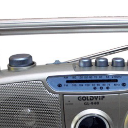

In [47]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [48]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

358 µs ± 9.61 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's a little bit slower but still fast enough for our purpose, so we will use this. We then define a general crop transform and two subclasses: one to crop at the center (for validation) and one to randomly crop. Each time, the subclass only implements the way to get the four corners passed to PIL.

In [49]:
#export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz) == 2 else [sz[0], sz[0]])

def default_crop_size(w, h):
    return [w, w] if w < h else [h, h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR):
        self.resample, self.size = resample, process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w, h):
        return default_crop_size(w, h)
    
    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h):
        return (0, 0, w, h)
    
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
    
    def default_crop_size(self, w, h):
        return [w / self.scale, h / self.scale]
    
    def get_corners(self, w, h, wc, hc):
        w1 = (w-wc)//2
        h1 = (h-hc)//2
        return (w1, h1, w1 + wc, h1 + hc)

In [50]:
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]

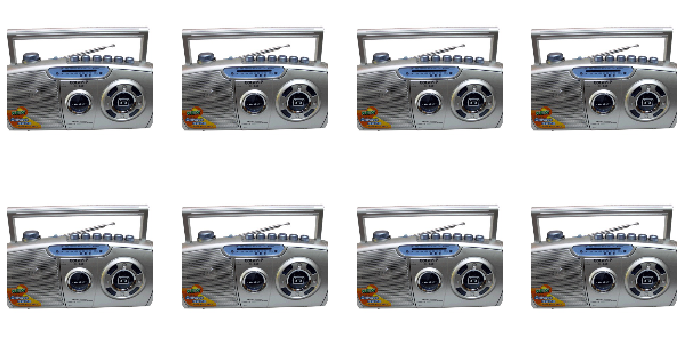

In [51]:
show_batch(next(iter(dl)))

### RandomResizeCrop

This is the usual data augmentation used on ImageNet (introduced [here](https://arxiv.org/pdf/1409.4842.pdf)) that consists of selecting 8 to 100% of the image area and a scale between 3/4 and 4/3 as a crop, then resizing it to the desired size. It combines some zoom and a bit of squishing at a very low computational cost.

In [52]:
#export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale, self.ratio = scale, ratio
        
    def get_corners(self, w, h, wc, hc):
        area = w * h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        # Fallback to squish
        if w / h < self.ratio[0]:
            size = (w, int(w / self.ratio[0]))
        elif w / h > self.ratio[1]:
            size = (int(h * self.ratio[1]), h)
        else:
            size = (w, h)
        
        return ((w - size[0]) // 2, (h - size[1]) // 2, (w + size[0]) // 2, (h + size[1]) // 2)

In [53]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

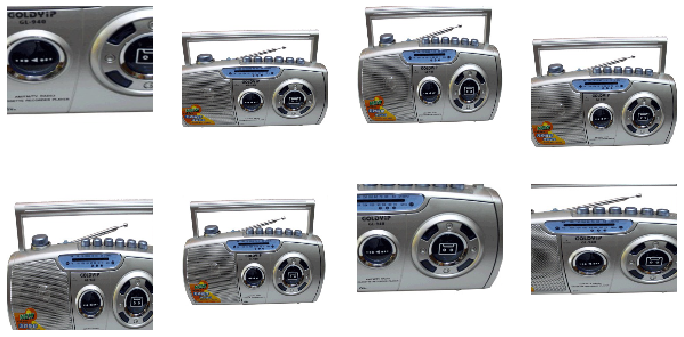

In [54]:
show_batch(next(iter(dl)))

### Perspective warping

To do perspective warping, we map the corners of the image to new points: for instance, if we want to tilt the image so that the top looks closer to us, the top/left corner needs to be shifted to the right and the top/right to the left. To avoid squishing, the bottom/left corner needs to be shifted to the left and the bottom/right corner to the right. For instance, if we have an image with corners in:
```
(60,60,60,280,280,280,280,60)
```
(top/left, bottom/left, bottom/right, top/right) then a warped version is:
```
(90,60,30,280,310,280,250,60)
```
PIL can do this for us but it requires 8 coefficients we need to calculate. The math isn't the most important here, as we've done it for you. We need to solve this [equation](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/). The equation solver is called `torch.solve` in PyTorch.

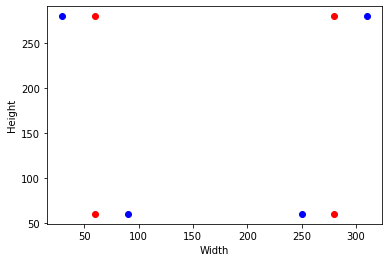

In [55]:
fig = plt.figure()
plt.xlabel('Width')
plt.ylabel('Height')
ax = fig.gca()
for l in [(60,60),(60,280),(280,280),(280,60)]:
    plt.plot(*l,'ro')
for l in [(90,60),(30,280),(310,280),(250,60)]:
    plt.plot(*l,'bo')

In [56]:
#export
from torch import FloatTensor, LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
        
    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B, A)[0][:,0])

In [57]:
# export

def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w, h = size
    targ_coords = ((0, 0), (0, h), (w, h), (w, 0))
    c = find_coeffs(src_coords, targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [58]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

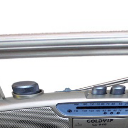

In [59]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

In [60]:
%timeit -n 10 warp(img, (128,128), src)

461 µs ± 8.15 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

152 µs ± 5.36 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


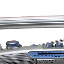

In [62]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

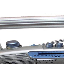

In [63]:
warp(img, (64,64), src, resample=PIL.Image.NEAREST)

In [64]:
#export
def uniform(a, b):
    return a + (b - a) * random.random()

In [65]:
[uniform(100, 200) for i in range(10)]

[120.50812875583041,
 179.26264954244095,
 158.3465917051668,
 150.41145040859686,
 123.85257827488667,
 118.39106883585788,
 192.63001535842812,
 136.402367216361,
 177.2152960891854,
 175.96427227879508]

We can add a transform to do this perspective warping automatically with the rand resize and crop.

In [66]:
FloatTensor([1]).shape, tensor([1.]).shape

(torch.Size([1]), torch.Size([1]))

In [67]:
tensor(1).float()

tensor(1.)

In [68]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0, resample=PIL.Image.NEAREST):
        self.resample,self.size,self.magnitude = resample, process_sz(size), magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        up_t, lr_t = uniform(-self.magnitude, self.magnitude), uniform(-self.magnitude, self.magnitude)
        left, top = randint(0, x.size[0] - csize[0]),  randint(0, x.size[1] - csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1 + lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left, top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [69]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

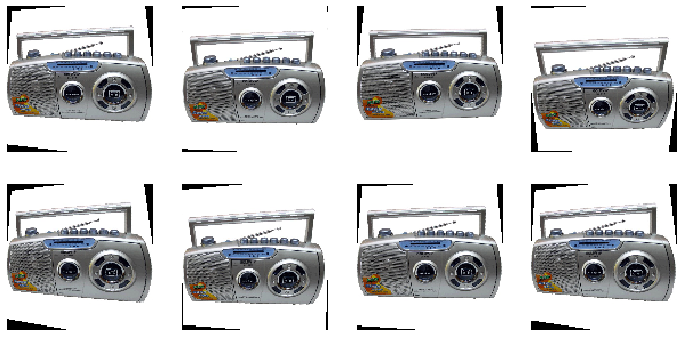

In [70]:
x = next(iter(dl))
show_batch(x)

Problem is that black padding appears as soon as our target points are outside of the image, so we have to limit the magnitude if we want to avoid that.

In [71]:
#export
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0, resample=PIL.Image.NEAREST):
        self.resample,self.size,self.magnitude = resample, process_sz(size), magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left, top = randint(0, x.size[0] - csize[0]),  randint(0, x.size[1] - csize[1])
        top_magn = min(self.magnitude, left / csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn = min(self.magnitude, top / csize[1], (x.size[1]-top)/csize[1]-1)
        up_t, lr_t = uniform(-top_magn, top_magn), uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1 + lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left, top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [72]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 200, magnitude=0.2), to_byte_tensor, to_float_tensor]

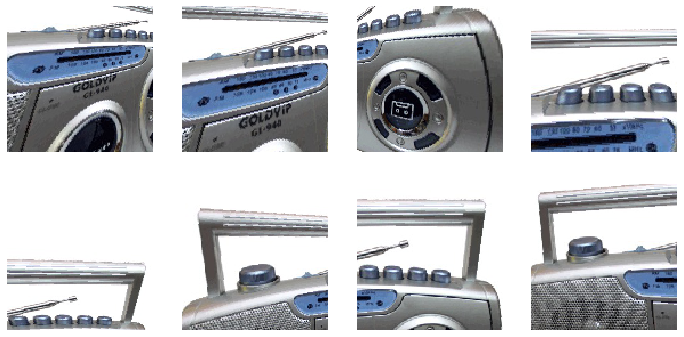

In [73]:
x = next(iter(dl))
show_batch(x)

### Faster tensor creation

In [74]:
[(o._order, o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7fd42cbe6ad0>),
 (11, <__main__.PilRandomDihedral at 0x7fd3c0291710>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

In [75]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [76]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

478 µs ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
%timeit -n 10 np_to_float(img)

568 µs ± 52.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Batch data augmentation

You can write your own augmentation for your domain's data types, and have them run on the GPU, by using regular PyTorch tensor operations. Here's an example for images. The key is to do them on a whole batch at a time. Nearly all PyTorch operations can be done batch-wise.

Once we have resized our images so that we can batch them together, we can apply more data augmentation on a batch level. For the affine/coord transforms, we proceed like this:
1. generate a grid map of the size of our batch (bs x height x width x 2) that contains the coordinates of a grid of size height x width (this will be the final size of the image, and doesn't have to be the same as the current size in the batch)
2. apply the affine transforms (which is a matrix multiplication) and the coord transforms to that grid map
3. interpolate the values of the final pixels we want from the initial images in the batch, according to the transformed grid map

For 1. and 3. there are PyTorch functions: `F.affine_grid` and `F.grid_sample`. `F.affine_grid` can even combine 1 and 2 if we just want to do an affine transformation.

### Step 1: generate the grid

In [78]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.2), to_byte_tensor, to_float_tensor]

In [79]:
dl = DataLoader(il1, 64)

In [80]:
x = next(iter(dl))

In [81]:
from torch import FloatTensor

In [82]:
def affine_grid_cpu(size):
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

In [83]:
grid = affine_grid_cpu(x.size())

In [84]:
grid.shape

torch.Size([64, 128, 128, 2])

In [85]:
grid[0, :5, :5]

tensor([[[-1.0000, -1.0000],
         [-0.9843, -1.0000],
         [-0.9685, -1.0000],
         [-0.9528, -1.0000],
         [-0.9370, -1.0000]],

        [[-1.0000, -0.9843],
         [-0.9843, -0.9843],
         [-0.9685, -0.9843],
         [-0.9528, -0.9843],
         [-0.9370, -0.9843]],

        [[-1.0000, -0.9685],
         [-0.9843, -0.9685],
         [-0.9685, -0.9685],
         [-0.9528, -0.9685],
         [-0.9370, -0.9685]],

        [[-1.0000, -0.9528],
         [-0.9843, -0.9528],
         [-0.9685, -0.9528],
         [-0.9528, -0.9528],
         [-0.9370, -0.9528]],

        [[-1.0000, -0.9370],
         [-0.9843, -0.9370],
         [-0.9685, -0.9370],
         [-0.9528, -0.9370],
         [-0.9370, -0.9370]]])

In [86]:
%timeit -n 10 grid = affine_grid_cpu(x.size())

978 µs ± 99.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Coords in the grid go from -1, to 1 (PyTorch convention).

PyTorch version is slower on the CPU but optimized to go very fast on the GPU

In [87]:
m = tensor([[1., 0., 0.], [0., 1., 0.]])
theta = m.expand(x.size(0), 2, 3)

In [88]:
theta.shape

torch.Size([64, 2, 3])

In [89]:
%timeit -n 10 grid = F.affine_grid(theta, x.size())

2.67 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [90]:
%timeit -n 10 grid = F.affine_grid(theta.cuda(), x.size())

The slowest run took 29.00 times longer than the fastest. This could mean that an intermediate result is being cached.
2.94 ms ± 5.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we write our own version that dispatches on the CPU with our function and uses PyTorch's on the GPU.

In [91]:
def affine_grid(x, size):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    if x.device.type == 'cpu': return affine_grid_cpu(size) 
    m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [92]:
grid = affine_grid(x, 128)

In [93]:
x.shape, grid.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128, 2]))

### Step 2: Affine multiplication

In 2D an affine transformation has the form y = Ax + b where A is a 2x2 matrix and b a vector with 2 coordinates. It's usually represented by the 3x3 matrix
```
A[0,0]  A[0,1]  b[0]
A[1,0]  A[1,1]  b[1]
   0       0     1
```
because then the composition of two affine transforms can be computed with the matrix product of their 3x3 representations.

In [94]:
from torch import stack,zeros_like,ones_like

The matrix for a rotation that has an angle of `theta` is:
```
cos(theta) -sin(theta) 0
sin(theta)  cos(theta) 0
0           0          1
```
Here we have to apply the reciprocal of a regular rotation (exercise: find why!) so we use this matrix:
```
 cos(theta) sin(theta) 0
-sin(theta) cos(theta) 0
 0          0          1
```
then we draw a different `theta` for each version of the image in the batch to return a batch of rotation matrices (size `bs x 3 x 3`).

In [95]:
t = tensor([1, 1, 2])
stacked = stack([t, t, t], dim=0)
t.shape, stacked.shape, stacked

(torch.Size([3]),
 torch.Size([3, 3]),
 tensor([[1, 1, 2],
         [1, 1, 2],
         [1, 1, 2]]))

In [96]:
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)

In [97]:
thetas = torch.empty(x.size(0)).uniform_(-30,30)

In [98]:
thetas[:5]

tensor([ 14.4685, -17.6170,  12.2355,  -3.9086, -12.7217])

In [99]:
m = rotation_matrix(thetas)

In [100]:
m.shape, m[:,None].shape, grid.shape

(torch.Size([64, 3, 3]),
 torch.Size([64, 1, 3, 3]),
 torch.Size([64, 128, 128, 2]))

In [101]:
grid.view(64,-1,2).shape

torch.Size([64, 16384, 2])

We have to apply our rotation to every point in the grid. The matrix a is given by the first two rows and two columns of `m` and the vector `b` is the first two coefficients of the last column. Of course we have to deal with the fact that here `m` is  a batch of matrices.

In [102]:
a = m[:,:2,:2]
b = m[:, 2:,:2]
tfm_grid = (grid.view(64,-1,2) @ a + b).view(64, 128, 128, 2)

In [103]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

5.95 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

5.27 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

5.81 ms ± 74.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

6.13 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And on the GPU

In [107]:
grid = grid.cuda()
m = m.cuda()

In [108]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

65.7 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

69 µs ± 8.41 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

63.5 µs ± 6.71 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [111]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

41.7 µs ± 3.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Step 3: interpolate

Since `bmm` is always the fastest, we use this one for the matrix multiplication.

In [112]:
tfm_grid = torch.bmm(grid.view(64,-1,2), m[:,:2,:2]).view(-1, 128, 128, 2)

The interpolation to find our coordinates back is done by `grid_sample`.

In [113]:
tfm_x = F.grid_sample(x, tfm_grid.cpu())

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


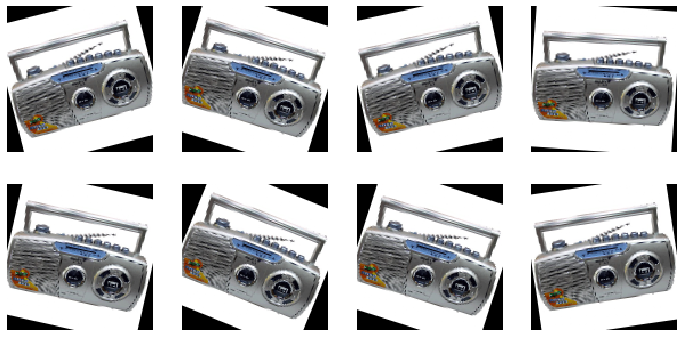

In [114]:
show_batch(tfm_x, r=2)

It takes a `padding_mode` argument.

In [115]:
tfm_x = F.grid_sample(x, tfm_grid.cpu(), padding_mode='reflection')

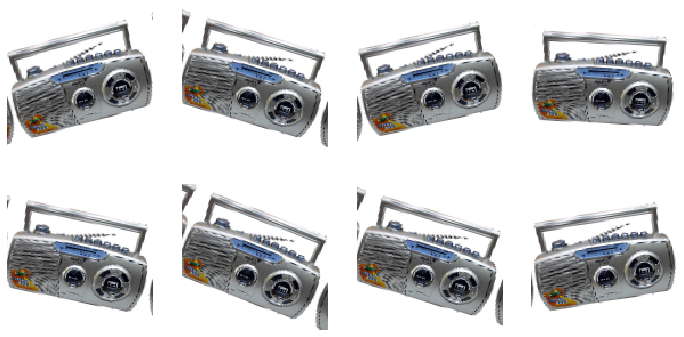

In [116]:
show_batch(tfm_x, r=2)

### Timing

Let's look at the speed now!

In [119]:
def rotate_batch(x, size, degrees):
    grid = affine_grid(x, size)
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = grid @ m[:,:2,:2].unsqueeze(1) + m[:,2,:2][:,None,None]
    return F.grid_sample(x, tfm_grid, padding_mode='reflection')

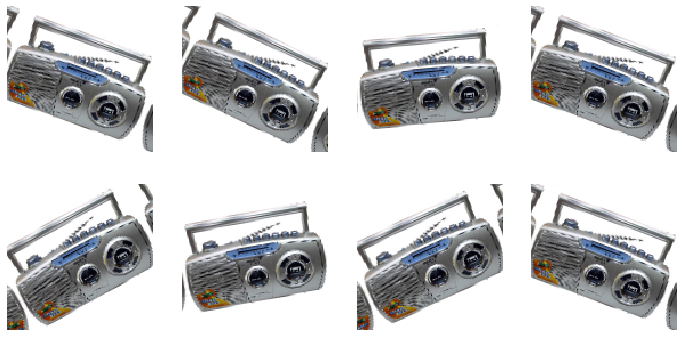

In [120]:
show_batch(rotate_batch(x, 128, 30), r=2)

In [121]:
%timeit -n 10 tfm_x = rotate_batch(x, 128, 30)

16.2 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [122]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

4.13 ms ± 588 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Jit version

But we can be even faster!

In [123]:
from torch import Tensor

In [131]:
from torch.jit import script

@script
def rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    sz = (x.size(0),x.size(1)) + (size,size)
    idm = torch.zeros(2,3, device=x.device)
    idm[0,0] = 1.
    idm[1,1] = 1.
    grid = F.affine_grid(idm.expand(x.size(0), 2, 3), sz)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2].unsqueeze(1).unsqueeze(2)
    return F.grid_sample(x, tfm_grid)

In [132]:
m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)

In [133]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners

3.97 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners